In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Resize
from torchvision.io import read_image, ImageReadMode
# import torchmetrics
import torch.nn.functional as F
import numpy as np

print(torch.__version__)

1.9.0+cpu


In [4]:
from albumentations import HorizontalFlip, Rotate, RandomBrightnessContrast, Flip, Compose, RandomResizedCrop
from typing import List, Optional, Dict, Generator, NamedTuple, Any, Tuple, Union, Mapping

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from multiprocessing import Pool

In [55]:
import gc
import math
from tqdm import tqdm
import time

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cpu device


In [7]:
epochs = 20

classes = 3
batch_size = 32

image_w = 224
image_h = 224

In [11]:
nih_path = "selected_xray/aj-sira/"
label_filepath = "label/file_label.csv"

## Prepare Data

In [20]:
def get_nih_filepath(path):
    image_path = []

    for i in os.listdir(path):
        image_path.append(path+i)
    return image_path

def read_path_file(file_path):
    f = open(file_path,"r")
    return f.read().splitlines()

def get_dict_from_csv(array):
    dic = {}
    for i in array:
        dic[i[0]] = i[1:]
    return dic

def map_path_label(path_list,label_dict):
    X = []
    y = []
    for i in path_list:
        split_path = i.split('/')[-1]
        if split_path in label_dict:
            X.append(i)
            y.append(label_dict[split_path])
    return X, y

def read_text(path):
  arr = open(path).read().split('\n')
  new_arr = []
  for i in range(len(arr)):
    arr[i] = nih_path+arr[i]
  return arr

def split_train_val_test(x,y):
    X_train = []
    y_train = []
    
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    
    train = read_text("label/train.txt")
    val = read_text("label/val.txt")
    test = read_text("label/test.txt")

    for i in range(len(x)):
      if x[i] in train:
          X_train.append(x[i])
          y_train.append(y[i])
          
      elif x[i] in val:
          X_val.append(x[i])
          y_val.append(y[i])
          
      else:
          X_test.append(x[i])
          y_test.append(y[i])

    return  np.array(X_train), \
            np.array(X_val), \
            np.array(X_test), \
            np.array(y_train).astype('float'), \
            np.array(y_val).astype('float'), \
            np.array(y_test).astype('float')

In [12]:
nih_image_path = get_nih_filepath(nih_path)

In [13]:
len(nih_image_path)

23422

In [21]:
data_entry = pd.read_csv(label_filepath)
data_entry_array = data_entry.values

In [22]:
data_label_dict = get_dict_from_csv(data_entry_array)

In [23]:
X,y = map_path_label(nih_image_path,data_label_dict)

In [24]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y)

## Create PyTorch Dataset

In [31]:
class XRayDataset(Dataset):
    def __init__(self, img_labels, img_files, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_files = img_files
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = read_image(img_path, mode=ImageReadMode.GRAY)/255
        label = self.img_labels[idx]
        if self.transform:
            image = image[0].numpy()
            aug = self.transform(image=image)
            image = torch.from_numpy(aug["image"])
            image = image.unsqueeze(0)
        if self.target_transform:
            label = self.target_transform(label)
        image = image.unsqueeze(0)
        image = F.interpolate(image, size=image_w)
        image = image[0]
        image = image.expand(3, -1, -1)
        return image, label

In [32]:
def augment(p=0.5):
    return Compose([
        RandomResizedCrop(image_h,image_w,scale=(0.7, 1.0), p=1.0),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(0.5,0.5,p=0.5),
        Rotate(90, border_mode=0, p=0.5),
    ], p=p)
augmentation = augment()

In [50]:
train_dataset = XRayDataset(y_train[:10], X_train[:10], transform=augmentation)
test_dataset = XRayDataset(y_test[:10], X_test[:10])
valid_dataset = XRayDataset(y_val[:10], X_val[:10])

torch.Size([3, 224, 224])
[0. 0. 0.]


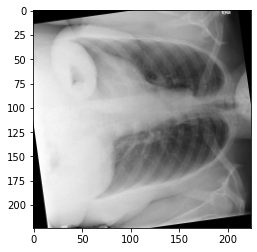

In [48]:
image, label = train_dataset[20]
print(image.size())
print(train_dataset[20][1])
plt.imshow(image[0], cmap='gray')

In [51]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## Densenet

In [30]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, classes)
model.train()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [52]:
model = model.to(device)

In [59]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

In [61]:
epochs = 3
loss_arr = []
val_loss_arr = []

for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs-1}')

    running_loss = 0.0
    s = time.time()
    # Iterate over data.
    n_total_steps = len(train_dataloader)
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):  
        images = images.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            if (i+1) % 50 == 0:
                print (f'[Train] Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, time: {(time.time()-s):.4f}s')
                s = time.time()
    epoch_loss = running_loss / len(train_dataset)
    loss_arr.append(epoch_loss)
    print (f'[Train] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')

    running_loss = 0.0
    s = time.time()
    n_total_steps = len(valid_dataloader)
    model.eval()
    for i, (images, labels) in enumerate(valid_dataloader):  
        images = images.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(valid_dataset)
    val_loss_arr.append(epoch_loss)
    print (f'[Eval] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')
    print('-' * 10)

Epoch 0/2
[Train] Epoch 0/2, Loss: 0.6248
[Eval] Epoch 0/2, Loss: 0.6908
----------
Epoch 1/2
[Train] Epoch 1/2, Loss: 0.5857
[Eval] Epoch 1/2, Loss: 0.6879
----------
Epoch 2/2
[Train] Epoch 2/2, Loss: 0.6573
[Eval] Epoch 2/2, Loss: 0.6864
----------


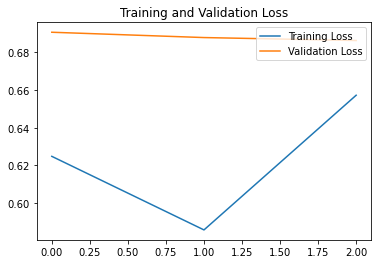

In [62]:
plt.plot(range(epochs), loss_arr, label='Training Loss')
plt.plot(range(epochs), val_loss_arr, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()